In [ ]:
!pip install --upgrade keras==3.1.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.1 requires keras>=3.2.0, but you have keras 3.1.1 which is incompatible.


In [ ]:
!pip install --upgrade tensorflow==2.16.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 114.2 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.16.1 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import numpy as np

import random

import os

import tensorflow as tf

import re

from tqdm import tqdm




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
color_img = []
gray_img = []

In [6]:
color_img = list(np.load('/content/drive/MyDrive/python/restorasyon/Dataset/KaggleDataset/color_img.npy'))
gray_img = list(np.load('/content/drive/MyDrive/python/restorasyon/Dataset/KaggleDataset/gray_img.npy'))

In [ ]:
def load_data(data_dir, size):
    count = 0
    for filename in tqdm(os.listdir(data_dir)):
        image = cv2.imread(os.path.join(data_dir, filename))
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)



        image = cv2.resize(image, dsize=size)
        gray = cv2.resize(gray, dsize=size)

        image = image.astype('float32') / 255.0
        gray = gray.astype('float32') / 255.0

        color_img.append(np.array(image.reshape(-1,256,256,3)))
        gray_img.append(np.array(gray.reshape(-1,256,256,3)))

        count += 1
        if count == 10:
            print("Durduruldu")
            break

    print("Dosyalar Yüklendi")

load_data("/content/drive/MyDrive/python/Dataset/humans", (256,256))

  0%|          | 9/3460 [00:09<1:01:09,  1.06s/it]

Durduruldu
Dosyalar Yüklendi


In [8]:
from keras.models import load_model

generator = load_model("/content/drive/MyDrive/python/restorasyon/main/generator_model_epoch50.h5")


generator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
def calculate_accuracy(real_img, generated_img, threshold=0.1):
    # Gerçek ve tahmin edilen görüntüler arasındaki farkı hesaplayın
    diff = np.abs(real_img - generated_img)
    # Farkın belirli bir eşikten küçük olduğu piksel sayısını hesaplayın
    correct_pixels = np.sum(diff < threshold)
    # Toplam piksel sayısını hesaplayın
    total_pixels = real_img.shape[0] * real_img.shape[1] * real_img.shape[2]
    # Doğruluk değerini hesaplayın
    accuracy = correct_pixels / total_pixels
    return accuracy

# Modelden tahmin edilen görüntüyü alın
generated_img = generator( gray_img[8], training=True)



# Gerçek görüntü (ground truth) ile karşılaştırma yaparak doğruluk hesaplayın
accuracy = calculate_accuracy( color_img[8], generated_img)
print(f"Accuracy: {accuracy}")


Accuracy: 2.99273681640625


In [ ]:
eval = generator.evaluate(gray_img[:100], color_img[:100])

ValueError: Layer 'functional_16' expected 1 input(s). Received 100 instead.

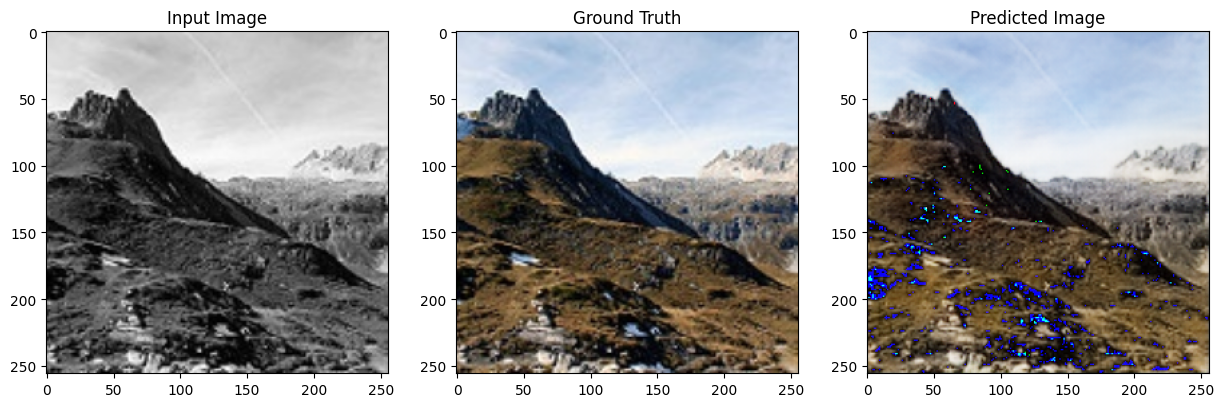

In [10]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)

    # BGR'den RGB'ye dönüşüm
    test_input_rgb = cv2.cvtColor((test_input[0]*255).astype('uint8'), cv2.COLOR_BGR2RGB)
    tar_rgb = cv2.cvtColor((tar[0]*255).astype('uint8'), cv2.COLOR_BGR2RGB)
    prediction_rgb = cv2.cvtColor((np.array(prediction[0])*255).astype('uint8'), cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15,15))

    display_list = [test_input_rgb, tar_rgb, prediction_rgb]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('on')
    plt.show()

    return prediction
import random
index = random.randint(0, len(gray_img))

pred = generate_images( generator, gray_img[index], color_img[index])


# Video



In [ ]:
def color_me(input_img, model):
  height, width, _ = input_img.shape
  input_img = cv2.resize(input_img, (256, 256))
  input_img = input_img.astype('float32') / 255.0

  input_img = input_img.reshape(-1, 256, 256, 3)
  prediction = model(input_img, training=True)

  cur = (np.array(prediction[0])*255).astype('uint8')


  cur = cv2.resize(cur, (width, height))

  return cur





In [ ]:
from IPython.display import clear_output


def colorize_video(input_video_path, output_video_name, model):

    cap = cv2.VideoCapture(input_video_path)

    # Video dosyasının genişliği ve yüksekliği alınır
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Video dosyası için bir VideoWriter nesnesi oluştur
    out = cv2.VideoWriter(f'{output_video_name}mp4', cv2.VideoWriter_fourcc(*'mpv4'), 30, (frame_width, frame_height))
    count = 0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    while True:
        ret, frame = cap.read()  # Bir sonraki kareyi oku
        if not ret:
            break  # Video bitti

        colored_frame = color_me(frame, model)  # Kareyi renklendir
        colored_frame = cv2.cvtColor(colored_frame, cv2.COLOR_RGB2BGR)
        out.write(colored_frame)  # Renklendirilmiş kareyi video dosyasına yaz


        clear_output(wait=True)
        count += 1
        per:float = count / total_frames * 100
        print(f"Frame % {per}f ")


    # Temizlik
    cap.release()
    out.release()


In [ ]:
import imageio
from tqdm import tqdm

def colorize_video(input_video_path, output_video_name, model):

    reader = imageio.get_reader(input_video_path)
    fps = reader.get_meta_data()['fps']
    writer = imageio.get_writer(f'{output_video_name}.mp4', fps=fps)

    total_frames = reader.count_frames()

    for i in tqdm(range(total_frames)):
        frame = reader.get_data(i)

        if frame is None:
            break

        colored_frame = color_me(frame, model)  # Kareyi renklendir

        writer.append_data(colored_frame)  # Renklendirilmiş kareyi video dosyasına yaz

    writer.close()



In [ ]:
from datetime import datetime

now = datetime.now()
name = now.strftime("%d%m%Y_%H%M%S")

input_video = "/content/drive/MyDrive/python/VID_48830720_044431_226.mp4"
output_video = f"/content/drive/MyDrive/python/d1sdsme.mp4"

colorize_video(input_video, output_video, generator)

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
 99%|█████████▉| 342/344 [00:34<00:00,  9.87it/s]


IndexError: 342

In [ ]:
import os.path

# Check if a file exists using its path.
file_path = "/content/drive/MyDrive/python/VID_48830720_044431_226.mp4"
if os.path.exists(file_path):
    print("The file exists.")
else:
    print("The file does not exist.")

In [ ]:
os.listdir("/content/drive/MyDrive/python")